## 走神司机识别
### 数据可视化，且用最P5的简单网络结构走通提交kaggle的流程

### 前置动作：检测设备的状态

In [24]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
tf.Session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16757935686737836397
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15577998951
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2586900720279401470
physical_device_desc: "device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0"
]


### 第1步：数据探索
#### 进行数据的统计学分析

In [5]:
from sklearn.datasets import load_files, load_sample_images
from keras.utils import np_utils
import os
import numpy as np
from glob import glob
import random
from pprint import pprint

random.seed(876543)

#定义函数来加载train和test数据集
def load_datasets(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']),10)
    return files, targets

root_path = "../../../data/distracted_driver_detection/unzip_data/"

train_files, train_targets = load_datasets(root_path + 'imgs/train')
test_files, test_targets = load_datasets(root_path + 'imgs/test')
driver_status = [item[64:-1] for item in sorted(glob(root_path + "imgs/train/*/"))]

print(driver_status)
#打印数据的统计描述
print("There are %d total driver status." % len(driver_status))
print("There are %d total driver images.\n" % len(np.hstack([train_files, test_files])))

print("There are %d total train driver images." % len(train_files))
print("There are %d total test driver images." % len(test_files))

print(train_targets)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
There are 10 total driver status.
There are 102150 total driver images.

There are 22424 total train driver images.
There are 79726 total test driver images.
[[0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


#### 进行数据的可视化
训练集中有22424张照片，已经按照类别将图片分类好了，下面统计了在训练数据中每种类型的样本数量，从统计结果来看，每种状态下的样本数量基本相同，在2000～2500张照片左右；测试集有79721张图片。图片的尺寸都是640*480。

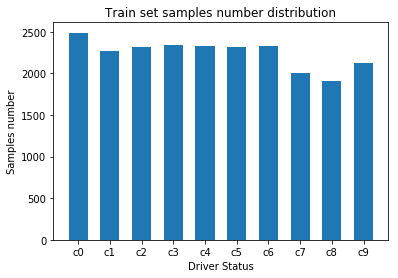

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
train_class_sample_num=[]

for n_class_dir in sorted(glob(root_path + "imgs/train/*/")):
    sample_num = len(glob(n_class_dir+'*'))
    train_class_sample_num.append(sample_num)

ind = np.arange(len(driver_status))
plt.bar(ind, train_class_sample_num, 0.6)
plt.xlabel('Driver Status')
plt.ylabel('Samples number')
plt.xticks(ind,driver_status)
plt.title('Train set samples number distribution')
plt.show()



项目还提供了一张与训练集图片对应的subject (driver) id，和class id的表格，从该表格中可以得到每个司机在不同分类中的数量。从下面的统计结果来看，p050,p051,p072号司机的状态分布与其他的有所不同，且各占总样本数量的3.5%，4.1%，1.5%，数量比较少在后面的训练中可以考虑去除。

/data/wanlijia/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


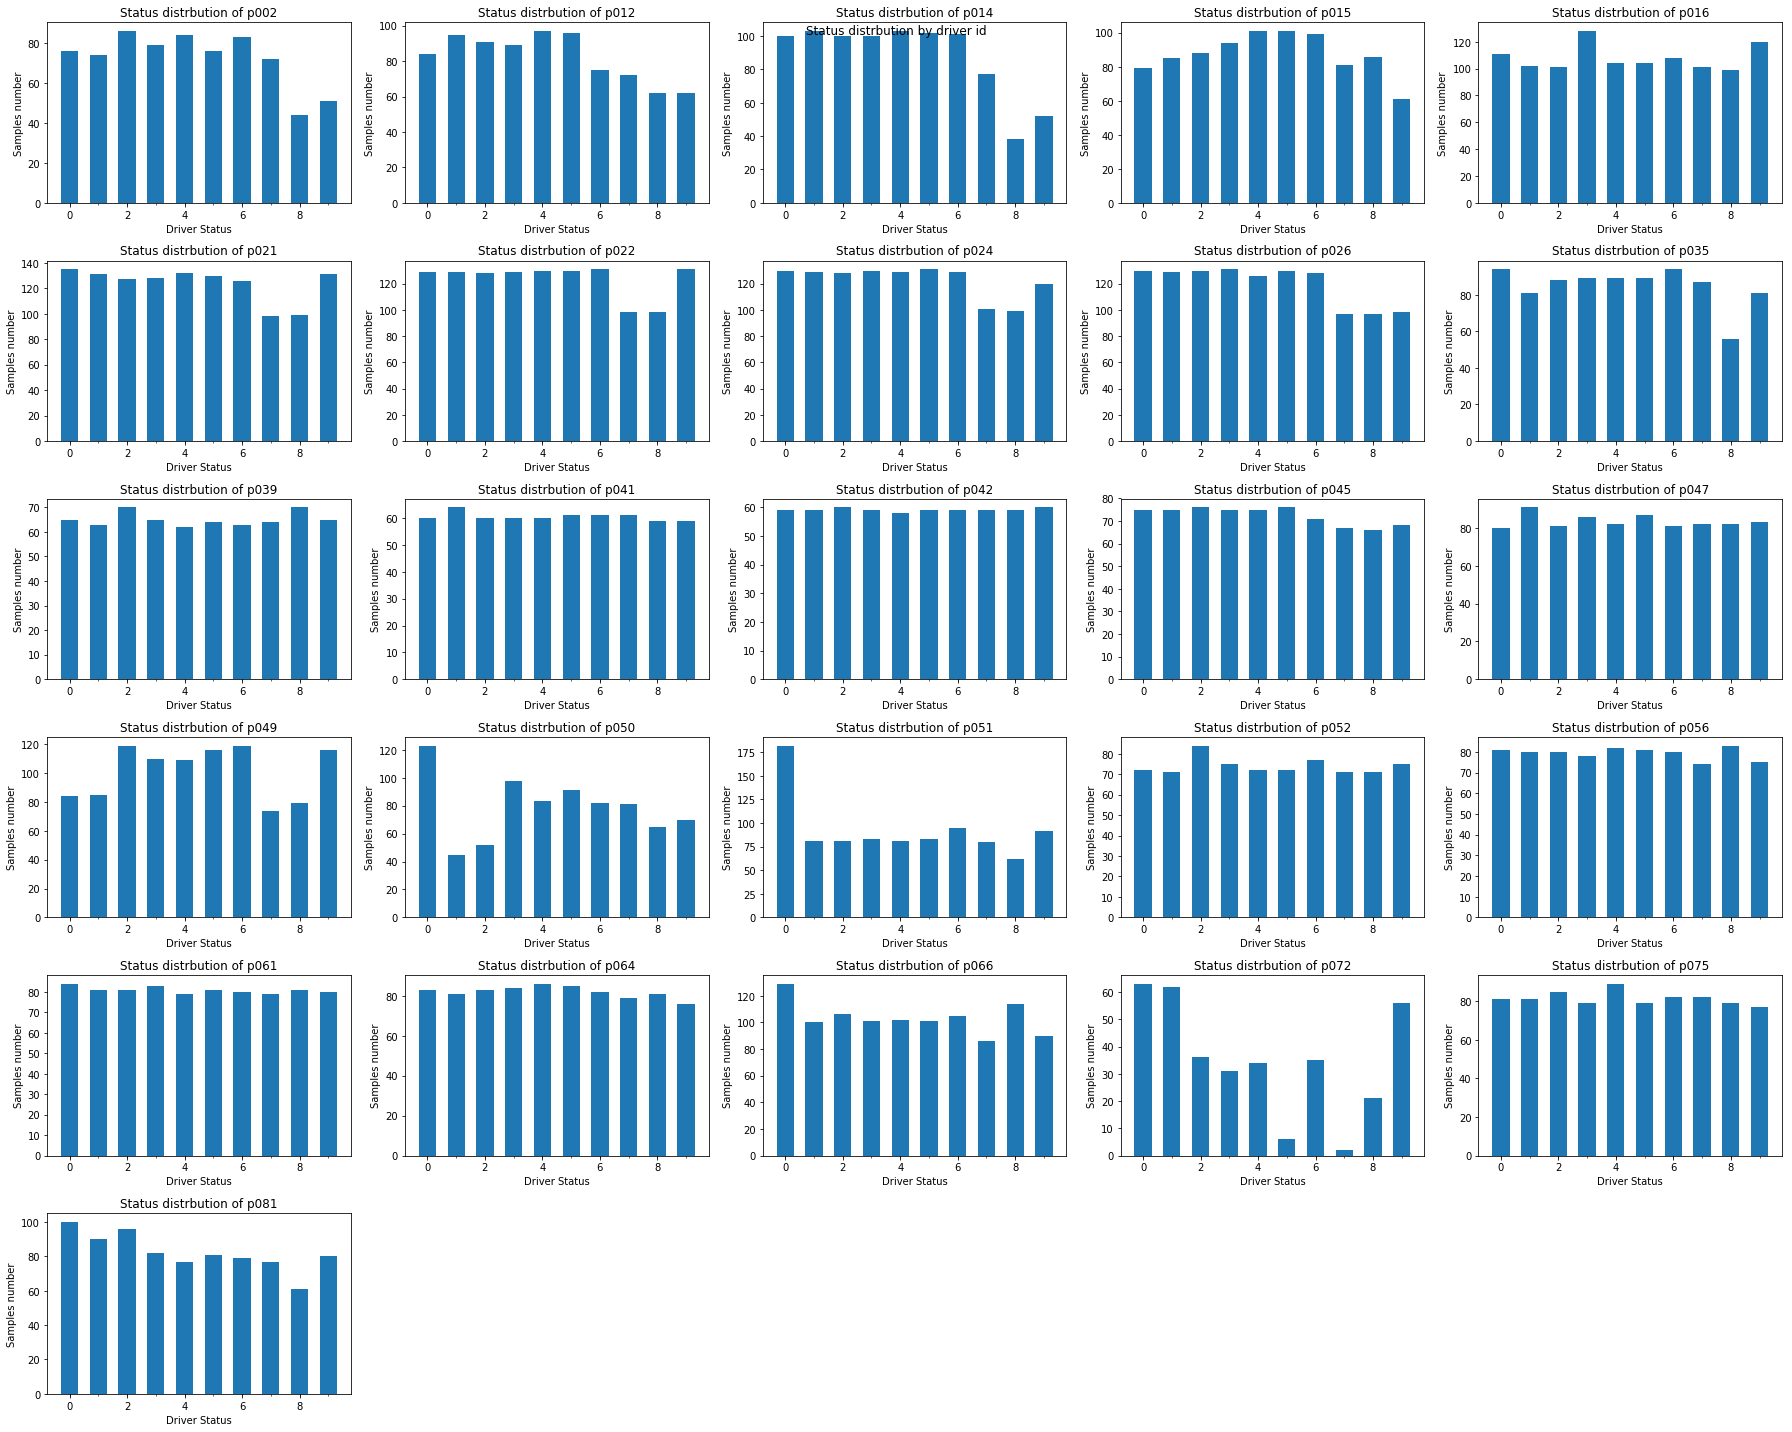

In [7]:
import pandas as pd

driver_list_data = pd.read_csv(root_path + 'driver_imgs_list.csv')

#司机编号
driver_id = []

#所有样本数量
sample_num = driver_list_data['subject'].size

for i in range(sample_num):
    if not driver_list_data['subject'][i] in driver_id:
        driver_id.append(driver_list_data['subject'][i])
fig = plt.figure(figsize=(25,20))
for i in range(len(driver_id)):
    ax=fig.add_subplot(6,5,i+1)
    #表示每种状态下的样本数量
    sample_num_temp = []
    for class_name in driver_status:
        sample_num_temp.append(driver_list_data[(driver_list_data.subject == driver_id[i]) & (driver_list_data.classname == class_name)].shape[0])
    ax.bar(ind, sample_num_temp, 0.6)
    ax.set_xlabel('Driver Status')
    ax.set_ylabel('Samples number')
    ax.set_xticks(ind,driver_status)
    ax.set_title('Status distrbution of %s'%(driver_id[i]))
fig.suptitle('Status distrbution by driver id')
fig.tight_layout()
fig.show()

### 第2步：建立模型
#### 实现一个简单的CNN网络
- 本项目采用巻积神经网络来识别司机的状态，采用keras框架，Tensorlow作为后端来搭建CNN网络。CNN的输入是一个4维张量，为(n_samples, rows, columns, channels)。其中n_samples表示样本的总数，rows, columns和channels分别表示图像的行数、列数和通道数。
- 下面是将图片进行预处理，转化为CNN网络的输入。


In [10]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path, img_nrows = None, img_ncols = None):
    # 用PIL加载RGB图像为PIL.Image.Image类型,将图像尺寸缩放到target_size
    #img_nrows,img_ncols: Either NULL (default to original size) or integer vector (img_height, img_width).
    img = image.load_img(img_path, target_size = (img_nrows,img_ncols))
    # 将PIL.Image.Image类型转化为格式为(img_nrows,img_ncols, 3)的3维张量
    x = image.img_to_array(img)
    # 将3维张量转化为格式为(1, target_size, 3)的4维张量并返回
    return np.expand_dims(x, axis = 0)

def paths_to_tensor(img_paths, img_nrows = None, img_ncols = None):
    list_of_tensor = [path_to_tensor(img_path, img_nrows, img_ncols) for img_path in tqdm(img_paths)]
    #返回(n_samples, target_size, 3)的4维张量
    return np.vstack(list_of_tensor)

In [11]:
#读取图像得到tensor，并进行归一化处理
from preprocess import *
from sklearn.utils import shuffle

train_tensors = paths_to_tensor(train_files,img_nrows = 224, img_ncols = 224).astype('float32')/255

from keras.preprocessing.image import ImageDataGenerator
 
gen = ImageDataGenerator(rescale = 1/255)
print(root_path + 'imgs/test')
test_generator = gen.flow_from_directory(root_path + 'imgs/test', (224,224), shuffle=False, batch_size=32)
test_file_names = test_generator.filenames

print(train_tensors.shape[1:])
print(test_generator)


100%|██████████| 22424/22424 [01:38<00:00, 227.24it/s]


../../../data/distracted_driver_detection/unzip_data/imgs/test
Found 79726 images belonging to 1 classes.
(224, 224, 3)


In [8]:
#这里的模型结构参考了P5的dog project中推荐的CNN网络家架构。主要目的是为了验证整个程序的流程是否正确。
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential

simple_model = Sequential()
simple_model.add(Conv2D(filters = 16, kernel_size=(2,2),strides=(1,1), padding='valid', input_shape = train_tensors.shape[1:]))
simple_model.add(MaxPooling2D(pool_size=(2,2), strides = None, padding='valid'))
simple_model.add(Conv2D(filters = 32, kernel_size=(2,2),strides=(1,1), padding='valid'))
simple_model.add(MaxPooling2D(pool_size=(2,2), strides = None, padding='valid'))
simple_model.add(Conv2D(filters = 64, kernel_size=(2,2),strides=(1,1), padding='valid'))
simple_model.add(MaxPooling2D(pool_size=(2,2), strides = None, padding='valid'))
simple_model.add(GlobalAveragePooling2D())
simple_model.add(Dropout(rate=0.5))
simple_model.add(Dense(10,activation='softmax'))
simple_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [8]:
#from keras.utils import multi_gpu_model
#simple_parallel_model = multi_gpu_model(simple_model, gpus=2)
#编译模型
simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#simple_parallel_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# 画出模型的结构图
from keras.utils import plot_model
import pydot
plot_model(simple_model, to_file='simple_model.png',show_shapes = True)

In [10]:
#下面使用model checkpointing来存储具有最低验证集loss的模型，并将训练过程中的
from keras.callbacks import ModelCheckpoint, CSVLogger

epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_weights/simple_model_best_weights.hdf5', 
                               verbose=1, save_best_only=True)
csv_logger = CSVLogger('log/simple_model_fit.log')
simple_model.fit(train_tensors, train_targets, 
          validation_split=0.2,shuffle=True,
          epochs=epochs, batch_size=20, callbacks=[checkpointer, csv_logger], verbose=1)


Train on 17939 samples, validate on 4485 samples
Epoch 1/10
17939/17939 [==============================] - 11s 638us/step - loss: 2.3029 - acc: 0.1128 - val_loss: 2.2990 - val_acc: 0.1159

Epoch 00001: val_loss improved from inf to 2.29901, saving model to saved_best_models/simple_model_best_weights.hdf5
Epoch 2/10
17939/17939 [==============================] - 10s 543us/step - loss: 2.2953 - acc: 0.1200 - val_loss: 2.2890 - val_acc: 0.1329

Epoch 00002: val_loss improved from 2.29901 to 2.28901, saving model to saved_best_models/simple_model_best_weights.hdf5
Epoch 3/10
17939/17939 [==============================] - 10s 542us/step - loss: 2.2852 - acc: 0.1332 - val_loss: 2.2799 - val_acc: 0.1369

Epoch 00003: val_loss improved from 2.28901 to 2.27990, saving model to saved_best_models/simple_model_best_weights.hdf5
Epoch 4/10
17939/17939 [==============================] - 10s 543us/step - loss: 2.2721 - acc: 0.1467 - val_loss: 2.2499 - val_acc: 0.1679

Epoch 00004: val_loss improved f

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


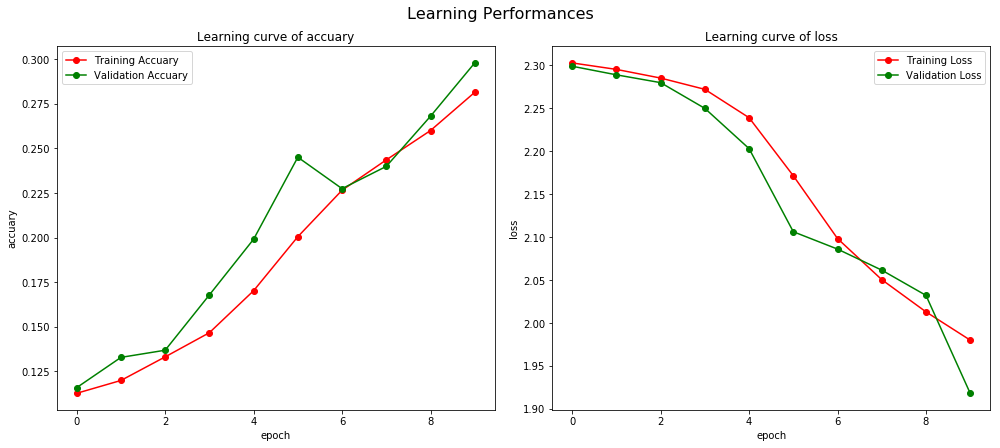

In [11]:
#画出学习曲线
import visuals as vs
vs.ModelLearning('log/simple_model_fit.log')


In [12]:
#加载具有最佳验证集loss的模型权重
simple_model.load_weights('saved_weights/simple_model_best_weights.hdf5')

In [13]:
#生成可提交的submission file
sub_df = pd.read_csv(root_path + "sample_submission.csv")

y_preds = simple_model.predict_generator(test_generator, verbose=1)
y_preds = y_preds.clip(min=0.005, max=0.995)
print("y_pred shape {}".format(y_preds.shape))

for i, fname in enumerate(test_generator.filenames):
    y_pred = y_preds[i]
    for k, c in enumerate(y_pred):
        sub_df.at[i, 'c'+str(k)] = c

sub_df.to_csv(root_path + 'pred_simple_model.csv', index=None)
print("predict done.")

Found 0 images belonging to 0 classes.
